# SSNet Predictions

This notebook is meant for hands-on interaction with the code and data used in `SSNet_predictions.py`. Annotations explaining the general functioning of each section and the other modules they reference are provided. Similar notebooks may be added for individual models and combiners in the future. Note that the code shown here does not necessarily reflect the content of the script version.

# License

In [1]:
'''
==================================================LICENSING TERMS==================================================
This code and data was developed by employees of the National Institute of Standards and Technology (NIST), an agency of the Federal Government. Pursuant to title 17 United States Code Section 105, works of NIST employees are not subject to copyright protection in the United States and are considered to be in the public domain. The code and data is provided by NIST as a public service and is expressly provided "AS IS." NIST MAKES NO WARRANTY OF ANY KIND, EXPRESS, IMPLIED OR STATUTORY, INCLUDING, WITHOUT LIMITATION, THE IMPLIED WARRANTY OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, NON-INFRINGEMENT AND DATA ACCURACY. NIST does not warrant or make any representations regarding the use of the data or the results thereof, including but not limited to the correctness, accuracy, reliability or usefulness of the data. NIST SHALL NOT BE LIABLE AND YOU HEREBY RELEASE NIST FROM LIABILITY FOR ANY INDIRECT, CONSEQUENTIAL, SPECIAL, OR INCIDENTAL DAMAGES (INCLUDING DAMAGES FOR LOSS OF BUSINESS PROFITS, BUSINESS INTERRUPTION, LOSS OF BUSINESS INFORMATION, AND THE LIKE), WHETHER ARISING IN TORT, CONTRACT, OR OTHERWISE, ARISING FROM OR RELATING TO THE DATA (OR THE USE OF OR INABILITY TO USE THIS DATA), EVEN IF NIST HAS BEEN ADVISED OF THE POSSIBILITY OF SUCH DAMAGES.
To the extent that NIST may hold copyright in countries other than the United States, you are hereby granted the non-exclusive irrevocable and unconditional right to print, publish, prepare derivative works and distribute the NIST data, in any medium, or authorize others to do so on your behalf, on a royalty-free basis throughout the world.
You may improve, modify, and create derivative works of the code or the data or any portion of the code or the data, and you may copy and distribute such modifications or works. Modified works should carry a notice stating that you changed the code or the data and should note the date and nature of any such change. Please explicitly acknowledge the National Institute of Standards and Technology as the source of the code or the data: Citation recommendations are provided below. Permission to use this code and data is contingent upon your acceptance of the terms of this agreement and upon your providing appropriate acknowledgments of NIST's creation of the code and data.
Paper Title:
    SSNet: a Sagittal Stratum-inspired Neural Network Framework for Sentiment Analysis
SSNet authors and developers:
    Apostol Vassilev:
        Affiliation: National Institute of Standards and Technology
        Email: apostol.vassilev@nist.gov
    Munawar Hasan:
        Affiliation: National Institute of Standards and Technology
        Email: munawar.hasan@nist.gov
    Jin Honglan
        Affiliation: National Institute of Standards and Technology
        Email: honglan.jin@nist.gov
====================================================================================================================
'''

'''
This is master file that runs all the three combiners proposed in the paper. 
Use following snippet to run all the three combiners: python SSNet_predictions.py
Please note that this code has tensorflow dependencies.
'''

'\nThis is master file that runs all the three combiners proposed in the paper. \nUse following snippet to run all the three combiners: python SSNet_predictions.py\nPlease note that this code has tensorflow dependencies.\n'

## Imports/Dependencies

TensorFlow is the main machine learning framework used to implement, train, and apply the models. Pandas and NumPy are used for general data preprocessing and manipulation. Components from Matplotlib/Pyplot and IPython which are absent from `SSNet_predictions.py` are utilized here to provide enhanced interactivity and visualization. Functions from the following scripts (corresponding to the combiner models described in the paper) are imported:
 - `SSNet_Neural_Network.py`
 - `SSNet_Bayesian_Decision.py`
 - `SSNet_Heuristic_Hybrid.py`

In [2]:
import tensorflow as tf
import math
import re

import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
from IPython.display import JSON
import itertools

from SSNet_Neural_Network import nn
from SSNet_Bayesian_Decision import bayesian_decision
from SSNet_Heuristic_Hybrid import heuristic_hybrid

In [3]:
imdb_5ktr = 'imdb_train_5k.csv'
model_a_tr = 'model_1_5ktrain.csv'
model_b_tr = 'model_2_5ktrain.csv'
# model_c_tr = 'model_3_bert_result_train_5k.csv'
# model_d_tr = 'model_4_use_result_train_5k.csv'
model_c_tr = 'model_3_5ktrain.csv'
model_d_tr = 'model_4_5ktrain.csv'

model_a_te = 'model_1_25ktest.csv'
model_b_te = 'model_2_25ktest.csv'
# model_c_te = 'model_3_bert_result_test_25k.csv'
# model_d_te = 'model_4_use_result_test_25k.csv'
model_c_te = 'model_3_25ktest.csv'
model_d_te = 'model_4_25ktest.csv'

## Utilities

### Training Dict Threshold

In [4]:
def get_training_dict_threshold(split):
    training_dict = dict()

    if split == "5K":
        training_dict["5K"] = [
            [model_a_tr, model_b_tr, model_c_tr, model_d_tr], [
                model_a_te, model_b_te, model_c_te, model_d_te]
        ]
        
    return training_dict

In [5]:
list(itertools.combinations('1234', 2))

[('1', '2'), ('1', '3'), ('1', '4'), ('2', '3'), ('2', '4'), ('3', '4')]

### Training Dictionary

In [10]:
def get_training_dict(split):
    training_dict = dict()
#     Store a running list of model combinations
#     included_models = []
    if split == "5K":
#         Loop through integers 2 to 4 (inclusive); the number of component models in each combination
        for r in range(2, 5):
#             Generate combinations of model indices (without repetition)
            for c in itertools.combinations(map(str, range(1, 5)), r):
                training_dict['model_{{{}}}'.format(','.join(c))] = [
#                     Generate the file names corresponding to each model's output on both the training and testing data
                    [f'model_{m}_{n}{t}.csv' for m in c] for n, t in [
                        ('5k', 'train'),
                        ('25k', 'test')
                    ]
                ]

    return training_dict

# Test the function
JSON(get_training_dict("5K"))

<IPython.core.display.JSON object>

In [10]:
imdb_25k_list = list()
data_dir = 'models/train'
for file_name in os.listdir(f'../{data_dir}/pos'):
    if file_name != '.DS_Store':
        imdb_25k_list.append([file_name, str(1)])

for file_name in os.listdir(f'../{data_dir}/neg'):
    if file_name != '.DS_Store':
        imdb_25k_list.append([file_name, str(0)])

SAMPLE_SPLIT = ["5K"]

## Train Predictors

Train the predictors and return the results.

In [11]:
def train_predictor():
    for split in SAMPLE_SPLIT:
        print("Sample Split: ", split)
        imdb_list = list()
        training_dict = None
        training_dict_threshold = None

        if split == "5K":
            df_imdb_tr = pd.read_csv(imdb_5ktr)
            for index in df_imdb_tr.index:
                file_name = str(df_imdb_tr['file'][index])
                label = int(df_imdb_tr['label'][index])
                imdb_list.append([file_name, str(label)])

            random.shuffle(imdb_list)
            training_dict = get_training_dict(split)
            training_dict_threshold = get_training_dict_threshold(split)

            random.shuffle(imdb_list)
            training_dict = get_training_dict(split)
            training_dict_threshold = get_training_dict_threshold(split)


        acc_dict_nn = dict()
        acc_dict_bdc = dict()

        for k, v in training_dict.items():

            tr_list = list()
            te_list = list()

            for i in range(len(v[0])):
                df = pd.read_csv(v[0][i])
                df_dict = dict()

                for idx in df.index:
                    file_name = str(df['file'][idx])
                    proba = float(df['prob'][idx])
                    df_dict[file_name] = proba

                tr_list.append(df_dict)

            for i in range(len(v[1])):
                df = pd.read_csv(v[1][i])
                df_dict = dict()

                for idx in df.index:
                    file_name = str(df['file'][idx])
                    proba = float(df['prob'][idx])
                    df_dict[file_name] = proba

                te_list.append(df_dict)


            assert len(tr_list) == len(te_list), "train and test samples mismatch ...."
            tr_acc = -1.
            te_acc = -1.
            while True:
                tr_acc, te_acc, weights = nn(tr_list=tr_list, imdb_tr_list=imdb_list,
                    te_list=te_list, imdb_te_list=imdb_25k_list)

                if weights[0][0] == 0. or weights[0][1] == 0.:
                    print("bad event ...., training again")
                    print("\t" +k)
                else:
                    break

            acc_dict_nn[k] = [tr_acc, te_acc]

            acc_dict_bdc[k] = bayesian_decision(tr_list=tr_list, imdb_tr_list=imdb_list,
                                             te_list=te_list, imdb_te_list=imdb_25k_list)


        for k, v in training_dict_threshold.items():
            tr_list = list()
            te_list = list()

            for i in range(len(v[0])):
                df = pd.read_csv(v[0][i])
                df_dict = dict()

                for idx in df.index:
                    file_name = str(df['file'][idx])
                    proba = float(df['prob'][idx])
                    df_dict[file_name] = proba

                tr_list.append(df_dict)

            for i in range(len(v[1])):
                df = pd.read_csv(v[1][i])
                df_dict = dict()

                for idx in df.index:
                    file_name = str(df['file'][idx])
                    proba = float(df['prob'][idx])
                    df_dict[file_name] = proba

                te_list.append(df_dict)

        hh_dict = heuristic_hybrid(tr_list=tr_list, imdb_tr_list=imdb_list,
                        te_list=te_list, imdb_te_list=imdb_25k_list)

        nn_metrics = []
        #print("Training Complete: ")
        print("Neural Network Combiner: ")
        for k, v in acc_dict_nn.items():
            print("\t" +k +": training accuracy = " +str(v[0]) + ", test accuracy = " +str(v[1]))
            nn_metrics.append(v)
            
        bdr_metrics = []
        print("\n")
        print("Bayesian Decision Rule Combiner: ")
        for k, v in acc_dict_bdc.items():
            print("\t" +k)
            for i, j in v.items():
                print("\t\t" +i +": training accuracy = " +str(j[0]) +", test accuracy = " +str(j[1]))
            bdr_metrics.append(v)
        
        hh_metrics = []
        print("\n")
        print("Heuristic-Hybrid Combiner: ")
        for k, v in hh_dict.items():
            print("Base:", k)
            for index in range(len(v)):
                print("\t\t", v[index])
            print("\n")
            hh_metrics.append(v)
            
        return nn_metrics, bdr_metrics, hh_metrics

## Result Aggregation

Runs the predictor training script and displays the results

In [12]:
trials = []
for i in range(1):
    results = train_predictor()
    trials.append(results)

Sample Split:  5K
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
bad event ...., training again
	model_{1,2}
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
bad event ...., training again
	model_{1,2}
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
bad event ...., training again
	model_{1,3}
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
25000 25000
25000 25000
25000 25000
dict_keys(['loss', 'accuracy', 'binary_crossentropy'])
bad event ...., training again
	model_{1,2,3}
25

In [241]:
def to_list(d):
    L = [v for k, v in d.items()]
    return L

# Convert result dictionaries to lists
for k, t in enumerate(trials):
    for i in range(len(trials[k])):
        for j, m in enumerate(trials[k][i]):
        #     for k, v in m.items():
            if type(m) is dict:
                trials[k][i][j] = to_list(m)
            for j2, m2 in enumerate(m):
                if type(m2) is dict:
                    trials[k][i][j][j2] = to_list(m2)

In [242]:
JSON(list(trials))

<IPython.core.display.JSON object>

## Visualization of Results

In [286]:
b = trials[0][0]
# print(trials[0][0])

l = ['Train', 'Test']
combiner_names = [
    'Neural Network',
    'Bayesian Decision Rule',
    'Heuristic-Hybrid'
]
bdr_props = ['Max', 'Avg', 'Sum', 'Majority']
hh_props = l + ['Threshold']
label_data = [l, bdr_props, hh_props]

plt.style.use('ggplot')
def grouped_plot(C=0, sections=2, reduce=0):
    labels = [x.split('_')[-1] for x in get_training_dict('5K').keys()]
    values = trials[0][C]
#     print(values)
#     valshape = np.array(values).shape
#     if len(valshape) == 3:
#         values

    reduced = False
    combiner_type = combiner_names[C]
    if 'Bayesian' in combiner_type:
        for i, v in enumerate(values):
            for j, vi in enumerate(v):
                if type(vi) in [list, tuple]:
                    values[i][j] = vi[reduce]
    elif 'Heuristic' in combiner_type:
#         print(values)
        values = values[reduce]
#         print(values)
        
    if any(g in combiner_type for g in ['Bayesian', 'Heuristic']):
        reduced = True
    # plt.bar(labels, trials[0][0])

    pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    
#     sections = min(len(values[0]), sections)
    sections = min(len(label_data[C]), sections)
    for n in range(sections):
        sections_ = min(len(values[0]), sections)
        barwidth = (0.5/sections_)
#         V = [x[n] if n <= len(x) else None for x in values]
        V = []
        for x in values:
            try:
                V.append(x[n])
            except:
                V.append(0)
#         print(C, n, min(len(label_data[C]), n))
        section_labels = label_data[C][min(len(label_data[C])-1, n)]
        section_pos = pos+(barwidth*n)
#         print(V, section_labels, section_pos, labels)
        ax.bar(section_pos, V, barwidth, label=section_labels)

#     ticks = pos-(barwidth*sections/4)
    ticks = pos+(barwidth*round((sections-2)/2))
    # print(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)

    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Contributing Models')
    
    s = l[reduce] if reduced else ''
    title = f'{combiner_names[C]} Combiner | {s} Accuracy by Model'
    
#         title += ' - '+l[reduce]
    ax.set_title(title)

    ax.legend(loc='upper right')
    return ax
    # fig.tight_layout()
    

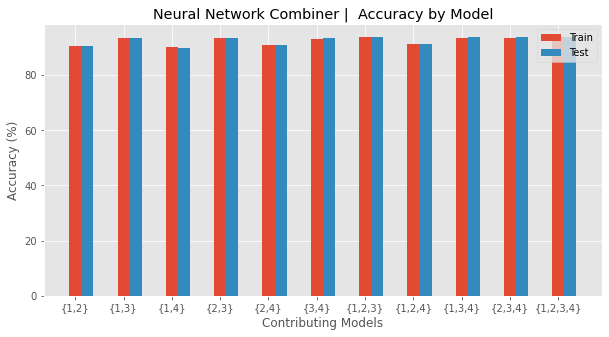

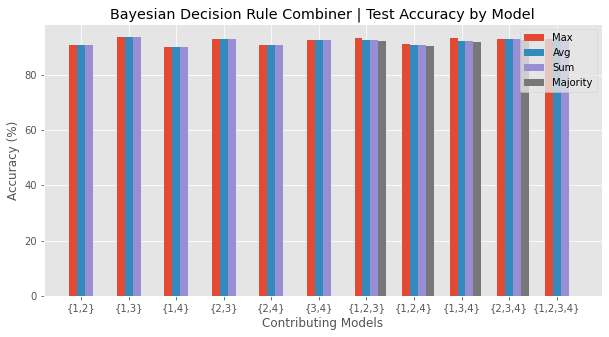

In [315]:
# Loop through the combiner indices and generate the graph for each one
for i in range(2):
    grouped_plot(C=i, sections=4, reduce=1)

In [4]:
a = {
    'a': 5,
    'b': 35,
    'c': 2.8
}
# plt.plot(a)